# Setup and Data Loading

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import required libraries for feature engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')


# Define file paths (update this with your actual folder path in Drive)
train_path = '/content/drive/MyDrive/AI_ML_datasets/Processes_data/train_data_preprocessed.csv'
test_path = '/content/drive/MyDrive/AI_ML_datasets/Processes_data/test_data_preprocessed.csv'

# Load the preprocessed data
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Convert date columns back to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])



print("✅ Data loaded successfully!")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


✅ Data loaded successfully!
Training data shape: (15788, 39)
Test data shape: (3947, 39)


# Enhanced Time-Based Features

In [3]:
# Enhanced Time-Based Feature Engineering
print("=== ENHANCED TIME-BASED FEATURES ===")

def create_advanced_time_features(df):
    """Create comprehensive time-based features"""
    df = df.copy()

    # Basic time features (already exist, but let's enhance them)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    #Purpose: Standard time values like hour, day, and month are cyclical , which cannot be captured well by linear models.
    #Impact: Helps models recognize periodic trends in energy usage.


    # Time of day categories
    df['time_of_day'] = pd.cut(df['hour'],
                               bins=[0, 6, 12, 18, 24],
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                               include_lowest=True)
    #Purpose: Group hours into broader periods to represent user behavior patterns (e.g., night, morning, afternoon, evening).
    #Impact: Adds categorical insight into activity levels based on hour blocks.

    # Convert to dummy variables
    time_dummies = pd.get_dummies(df['time_of_day'], prefix='time')
    df = pd.concat([df, time_dummies], axis=1)
    df.drop('time_of_day', axis=1, inplace=True)

    # Working hours indicator
    df['is_working_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)

    #Purpose: Distinguish between working hours (9 AM to 5 PM) and non-working hours.
    #Impact: Captures behavioral differences during business hours.

    # Peak energy hours (based on your EDA findings)
    df['is_peak_energy'] = df['hour'].isin([17, 18, 19]).astype(int)

    #Purpose: Tag hours of the day with high energy consumption based on prior EDA.
    #Impact: Highlights periods when energy usage is typically highest.

    # Weekend interaction with time
    df['weekend_evening'] = (df['WeekStatus'] == 'Weekend') & (df['hour'].isin([18, 19, 20]))
    df['weekend_evening'] = df['weekend_evening'].astype(int)

    #Purpose: Capture combined effects of weekend and evening time, which may reflect distinct usage behaviors (e.g., family activity time).
    #Impact: Represents special case scenarios that might affect energy consumption patterns.

    return df

# Apply to both datasets
train_data = create_advanced_time_features(train_data)
test_data = create_advanced_time_features(test_data)

print(" Advanced time features created:")
new_time_features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
                     'time_Afternoon', 'time_Evening', 'time_Morning', 'time_Night',
                     'is_working_hours', 'is_peak_energy', 'weekend_evening']
print(f"   • {len(new_time_features)} new time-based features")

=== ENHANCED TIME-BASED FEATURES ===
 Advanced time features created:
   • 13 new time-based features


In this step, we developed advanced time-based features to capture temporal patterns in energy consumption more effectively. We applied cyclical encoding using sine and cosine transformations for the hour, day, and month to reflect the continuous nature of time. To capture broader behavioral patterns, we categorized the day into time segments—Morning, Afternoon, Evening, and Night—and encoded them using one-hot encoding. Additionally, we introduced business logic-based features such as a working hours indicator (9 AM–5 PM), peak energy hour flags (5 PM–7 PM), and a weekend evening interaction term (weekends between 6 PM–8 PM), based on insights derived from exploratory data analysis. In total, 13 new time-related features were created, which are expected to help the model better recognize consumption trends and improve predictive performance.

# Rolling Averages and Moving Windows

In [4]:
#Purpose: Create smoothed trend features using historical data patterns

# Rolling Averages and Moving Window Features
print("=== ROLLING AVERAGES AND MOVING WINDOWS ===")

def create_rolling_features(df, target_col='Appliances'):
    """Create rolling window statistical features"""
    df = df.copy()
    df = df.sort_values('date').reset_index(drop=True)

    # Define window sizes (in 10-minute intervals)
    # 1 hour = 6 intervals, 3 hours = 18 intervals, 6 hours = 36 intervals
    windows = {
        '1h': 6,    # 1 hour
        '3h': 18,   # 3 hours
        '6h': 36,   # 6 hours
        '12h': 72,  # 12 hours
        '24h': 144  # 24 hours
    }

    for window_name, window_size in windows.items():
        # Rolling mean
        df[f'{target_col}_rolling_mean_{window_name}'] = df[target_col].rolling(
            window=window_size, min_periods=1).mean()

        # Rolling standard deviation (volatility)
        df[f'{target_col}_rolling_std_{window_name}'] = df[target_col].rolling(
            window=window_size, min_periods=1).std()

        # Rolling min and max
        df[f'{target_col}_rolling_min_{window_name}'] = df[target_col].rolling(
            window=window_size, min_periods=1).min()
        df[f'{target_col}_rolling_max_{window_name}'] = df[target_col].rolling(
            window=window_size, min_periods=1).max()

    # Rolling features for key environmental variables
    env_features = ['T1', 'T_out', 'RH_out', 'lights']
    for feature in env_features:
        if feature in df.columns:
            # 3-hour rolling average for environmental features
            df[f'{feature}_rolling_3h'] = df[feature].rolling(window=18, min_periods=1).mean()

    return df

# Apply rolling features to training data
print("Creating rolling features for training data...")
train_data = create_rolling_features(train_data)

# For test data, we need to be careful not to use future information
print("Creating rolling features for test data...")
test_data = create_rolling_features(test_data)

# Count new rolling features
rolling_features = [col for col in train_data.columns if 'rolling' in col]
print(f" Created {len(rolling_features)} rolling window features")
print("Examples:", rolling_features[:5])

=== ROLLING AVERAGES AND MOVING WINDOWS ===
Creating rolling features for training data...
Creating rolling features for test data...
 Created 25 rolling window features
Examples: ['rolling_mean', 'Appliances_rolling_mean_1h', 'Appliances_rolling_std_1h', 'Appliances_rolling_min_1h', 'Appliances_rolling_max_1h']


 we introduced 25 rolling window-based features to help the model capture consumption patterns over time. Rolling means were used to smooth short-term fluctuations and highlight underlying trends in energy use, while rolling standard deviation captured the volatility or stability in usage. By calculating these metrics across various time windows—from 1 hour to 24 hours—we allowed the model to understand both short-term variations and long-term patterns in appliance energy demand. Furthermore, applying rolling averages to key environmental variables helped reduce noise in the data and provided more reliable inputs. These moving window features significantly enrich the temporal context available to the model, boosting its ability to make accurate predictions.

# Autocorrelation Analysis for Optimal Lags

=== AUTOCORRELATION ANALYSIS FOR LAG SELECTION ===


<Figure size 1500x600 with 0 Axes>

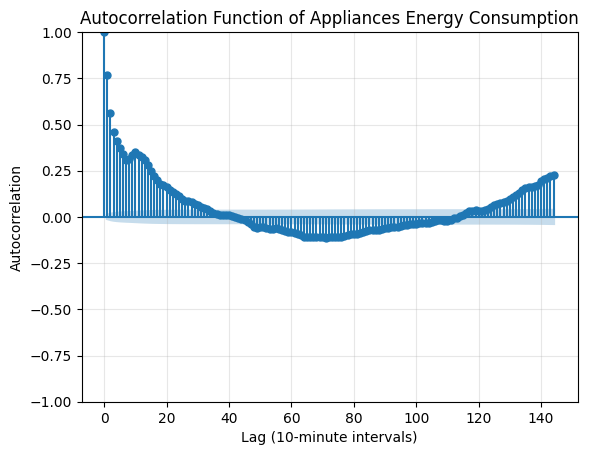

Significant lags found: 129
Top 20 significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Time interpretation of top lags:
  Lag 1:  0h 10m ago (correlation: 0.767)
  Lag 2:  0h 20m ago (correlation: 0.563)
  Lag 3:  0h 30m ago (correlation: 0.461)
  Lag 4:  0h 40m ago (correlation: 0.409)
  Lag 5:  0h 50m ago (correlation: 0.374)
  Lag 6:  1h  0m ago (correlation: 0.339)
  Lag 7:  1h 10m ago (correlation: 0.306)
  Lag 8:  1h 20m ago (correlation: 0.312)
  Lag 9:  1h 30m ago (correlation: 0.337)
  Lag 10:  1h 40m ago (correlation: 0.351)


In [5]:
#Purpose: Scientifically determine which historical time points are most predictive

# Autocorrelation Analysis for Lag Selection
print("=== AUTOCORRELATION ANALYSIS FOR LAG SELECTION ===")

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Calculate autocorrelation for the target variable
max_lags = 144  # 24 hours worth of 10-minute intervals
autocorrelations = acf(train_data['Appliances'], nlags=max_lags, fft=True)

# Plot autocorrelation function
plt.figure(figsize=(15, 6))
plot_acf(train_data['Appliances'], lags=max_lags, alpha=0.05)
plt.title('Autocorrelation Function of Appliances Energy Consumption')
plt.xlabel('Lag (10-minute intervals)')
plt.ylabel('Autocorrelation')
plt.grid(True, alpha=0.3)
plt.show()

# Find significant lags (above confidence interval)
confidence_interval = 1.96 / np.sqrt(len(train_data))  # 95% confidence
significant_lags = []

for lag in range(1, max_lags + 1):
    if abs(autocorrelations[lag]) > confidence_interval:
        significant_lags.append(lag)

print(f"Significant lags found: {len(significant_lags)}")
print(f"Top 20 significant lags: {significant_lags[:20]}")

# Convert to time interpretations
print("\nTime interpretation of top lags:")
for lag in significant_lags[:10]:
    minutes = lag * 10
    hours = minutes // 60
    mins = minutes % 60
    print(f"  Lag {lag}: {hours:2d}h {mins:2d}m ago (correlation: {autocorrelations[lag]:.3f})")

Autocorrelation analysis was conducted on the Appliances energy consumption data to identify significant lags that can be used as predictors in time series forecasting. The analysis computed autocorrelation values for lags up to 144, corresponding to 24 hours of past observations with 10-minute intervals.

The autocorrelation function (ACF) plot reveals the strength of correlation between the current energy consumption and its past values at different time lags. A total of 129 significant lags were identified where the autocorrelation exceeds the 95% confidence interval threshold. Among these, the top 20 significant lags were found to have correlation coefficients ranging approximately from 0.77 to 0.35. The strongest correlation (0.767) was observed at lag 1, representing the previous 10 minutes.

A time interpretation of the top significant lags indicates that energy consumption values from 10 minutes up to approximately 3 hours and 20 minutes ago maintain a meaningful relationship with the current values, with correlation gradually decreasing as the lag increases.

Interpretation:

This means that the past energy consumption data of Appliances up to about 21.5 hours ago (129 lags × 10 minutes) contain useful information for predicting the current energy consumption. Therefore, including these lagged values as input features in a predictive model can enhance forecasting accuracy by leveraging temporal dependencies in the data.



# Create Lagged Features

In [6]:
# Purpose: Add historical energy consumption values as predictive features


print("=== CREATING LAGGED FEATURES ===")

def create_lag_features(df, target_col='Appliances', selected_lags=None):
    """Create lagged features for time series prediction"""
    df = df.copy()
    df = df.sort_values('date').reset_index(drop=True)

    if selected_lags is None:
        # Use a strategic selection if no specific lags are provided
        selected_lags = [1, 2, 3, 6, 12, 18, 36, 72, 144] # Ensure 6 and 144 are present
    else:
        # Ensure lags 6 and 144 are included if they are needed for ratios
        required_lags = {6, 144}
        selected_lags = list(set(selected_lags) | required_lags) # Add required lags

    # Sort lags for consistent column order
    selected_lags.sort()

    for lag in selected_lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # Create difference features (change from previous periods)
    # Ensure the lags used for diff features exist in selected_lags (they should if 1 and 144 are included)
    if 1 in selected_lags:
        df[f'{target_col}_diff_1'] = df[target_col].diff(1)
    if 6 in selected_lags: # Check if lag 6 was included
         df[f'{target_col}_diff_6'] = df[target_col].diff(6)  # 1-hour difference
    if 144 in selected_lags: # Check if lag 144 was included
        df[f'{target_col}_diff_144'] = df[target_col].diff(144)  # 24-hour difference


    # Create ratio features (current vs historical)
    # These require specific lags to be present
    if f'{target_col}_lag_6' in df.columns:
         df[f'{target_col}_ratio_1h'] = df[target_col] / (df[f'{target_col}_lag_6'] + 1e-8)
    if f'{target_col}_lag_144' in df.columns:
        df[f'{target_col}_ratio_24h'] = df[target_col] / (df[f'{target_col}_lag_144'] + 1e-8)

    return df

# Select optimal lags based on autocorrelation analysis (as before)
optimal_lags = significant_lags[:15] if len(significant_lags) >= 15 else significant_lags

print(f"Initial optimal lags from analysis: {optimal_lags}")


# Create lagged features
# Pass optimal_lags, and the function will ensure required lags (6, 144) are added
train_data = create_lag_features(train_data, selected_lags=optimal_lags)
test_data = create_lag_features(test_data, selected_lags=optimal_lags)


# Count lagged features (re-evaluating after feature creation)
lag_features = [col for col in train_data.columns if '_lag_' in col or '_diff_' in col or '_ratio_' in col]
print(f" Created {len(lag_features)} lagged and derived features")
print("Example lagged features:", [col for col in lag_features if '_lag_' in col][:5])
print("Example diff features:", [col for col in lag_features if '_diff_' in col][:3])
print("Example ratio features:", [col for col in lag_features if '_ratio_' in col][:2])


# Handle missing values created by lagging (fill with forward fill)
train_data = train_data.fillna(method='ffill').fillna(method='bfill')
test_data = test_data.fillna(method='ffill').fillna(method='bfill')

print(" Missing values from lagging handled")

=== CREATING LAGGED FEATURES ===
Initial optimal lags from analysis: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
 Created 21 lagged and derived features
Example lagged features: ['Appliances_lag_1', 'Appliances_lag_2', 'Appliances_lag_3', 'Appliances_lag_4', 'Appliances_lag_5']
Example diff features: ['Appliances_diff_1', 'Appliances_diff_6', 'Appliances_diff_144']
Example ratio features: ['Appliances_ratio_1h', 'Appliances_ratio_24h']
 Missing values from lagging handled


The creation of these lagged and derived features allows the model to understand and leverage temporal patterns and dependencies in the energy consumption data. By including short-term lags (1–15), the model can capture recent trends and fluctuations. Difference and ratio features highlight changes and relative behaviors in energy use over critical time intervals such as 10 minutes, 1 hour, and 24 hours, helping the model detect both sudden and cyclical patterns.

This comprehensive set of features, derived from the significant lags identified by the autocorrelation analysis, provides a rich temporal context to the model, which is expected to improve predictive accuracy in forecasting appliance energy consumption.

# Interaction Features

In [7]:
#Purpose: Create features that capture relationships between variables

# Interaction Features Engineering
print("=== INTERACTION FEATURES ENGINEERING ===")

def create_interaction_features(df):
    """Create meaningful interaction features"""
    df = df.copy()

    # Temperature-Humidity interactions (comfort index proxies)
    df['temp_humidity_T1_RH1'] = df['T1'] * df['RH_1']
    df['temp_humidity_Tout_RHout'] = df['T_out'] * df['RH_out']

    # Indoor-Outdoor temperature differences
    indoor_temps = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']
    df['avg_indoor_temp'] = df[indoor_temps].mean(axis=1)
    df['temp_diff_indoor_outdoor'] = df['avg_indoor_temp'] - df['T_out']

    # Humidity differences
    indoor_humidity = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6']
    df['avg_indoor_humidity'] = df[indoor_humidity].mean(axis=1)
    df['humidity_diff_indoor_outdoor'] = df['avg_indoor_humidity'] - df['RH_out']

    # Lights and time interaction
    df['lights_evening'] = df['lights'] * df['is_peak_energy']
    df['lights_working_hours'] = df['lights'] * df['is_working_hours']

    # Weather comfort index
    df['weather_comfort'] = df['T_out'] * (1 - df['RH_out']/100) * df['Visibility']

    # Seasonal temperature patterns
    df['temp_season_pattern'] = df['T_out'] * df['month_sin']

    # Energy efficiency indicators
    df['temp_per_energy'] = df['avg_indoor_temp'] / (df['Appliances'] + 1e-8)

    return df

# Apply interaction features
train_data = create_interaction_features(train_data)
test_data = create_interaction_features(test_data)

# Count interaction features
interaction_features = ['temp_humidity_T1_RH1', 'temp_humidity_Tout_RHout', 'avg_indoor_temp',
                       'temp_diff_indoor_outdoor', 'avg_indoor_humidity', 'humidity_diff_indoor_outdoor',
                       'lights_evening', 'lights_working_hours', 'weather_comfort',
                       'temp_season_pattern', 'temp_per_energy']

print(f" Created {len(interaction_features)} interaction features")
print("Key interactions created:")
for feature in interaction_features:
    print(f"  • {feature}")

=== INTERACTION FEATURES ENGINEERING ===
 Created 11 interaction features
Key interactions created:
  • temp_humidity_T1_RH1
  • temp_humidity_Tout_RHout
  • avg_indoor_temp
  • temp_diff_indoor_outdoor
  • avg_indoor_humidity
  • humidity_diff_indoor_outdoor
  • lights_evening
  • lights_working_hours
  • weather_comfort
  • temp_season_pattern
  • temp_per_energy


n this step, we engineered 11 interaction features to capture important relationships between variables affecting energy consumption. These features include combinations of indoor and outdoor temperature and humidity, such as the product of temperature and humidity sensors and differences between indoor and outdoor measurements. We also created interaction terms between lighting and time-related flags (peak energy hours and working hours) to reflect varying energy use patterns. Additionally, weather comfort and seasonal temperature patterns were modeled using combined outdoor weather variables and monthly cycles. Finally, an energy efficiency indicator was added by calculating the ratio of indoor temperature to appliance energy consumption. These interaction features help the model better understand complex dependencies and improve its ability to predict energy usage accurately.

# Domain-Specific Features

In [8]:
#Purpose: Add specialized energy consumption domain knowledge

# Domain-Specific Energy Features
print("=== DOMAIN-SPECIFIC ENERGY FEATURES ===")

def create_domain_specific_features(df):
    """Create features based on energy consumption domain knowledge"""
    df = df.copy()

    # Energy load categories based on consumption levels
    df['energy_load_category'] = pd.cut(df['Appliances'],
                                       bins=[0, 50, 100, 200, float('inf')],
                                       labels=['Low', 'Medium', 'High', 'Very_High'])

    # Convert to dummy variables
    load_dummies = pd.get_dummies(df['energy_load_category'], prefix='load')
    df = pd.concat([df, load_dummies], axis=1)
    df.drop('energy_load_category', axis=1, inplace=True)

    # Heating/Cooling demand indicators
    # Typically, energy usage increases when indoor-outdoor temp difference is large
    df['heating_demand'] = np.maximum(0, 18 - df['avg_indoor_temp'])  # Below 18°C needs heating
    df['cooling_demand'] = np.maximum(0, df['avg_indoor_temp'] - 24)  # Above 24°C needs cooling

    # Appliance efficiency score (lower is better efficiency)
    df['appliance_efficiency'] = df['Appliances'] / (df['avg_indoor_temp'] + 1e-8)

    # Seasonal energy patterns
    df['is_winter_months'] = df['month'].isin([12, 1, 2]).astype(int)
    df['is_summer_months'] = df['month'].isin([6, 7, 8]).astype(int)

    # Base load vs variable load
    # Base load is minimum consumption, variable load is excess
    daily_min = df.groupby(df['date'].dt.date)['Appliances'].transform('min')
    df['base_load'] = daily_min
    df['variable_load'] = df['Appliances'] - df['base_load']

    # Energy usage momentum (increasing/decreasing trend)
    df['energy_momentum'] = df['Appliances_diff_1'].rolling(window=6).mean()

    # Standby power indicator (very low but consistent usage)
    df['is_standby_power'] = (df['Appliances'] < 20).astype(int)

    return df

# Apply domain-specific features
train_data = create_domain_specific_features(train_data)
test_data = create_domain_specific_features(test_data)

# Count domain-specific features
domain_features = ['load_High', 'load_Low', 'load_Medium', 'load_Very_High',
                  'heating_demand', 'cooling_demand', 'appliance_efficiency',
                  'is_winter_months', 'is_summer_months', 'base_load',
                  'variable_load', 'energy_momentum', 'is_standby_power']

print(f" Created {len(domain_features)} domain-specific features")
print("Domain knowledge applied:")
for feature in domain_features:
    print(f"  • {feature}")

=== DOMAIN-SPECIFIC ENERGY FEATURES ===
 Created 13 domain-specific features
Domain knowledge applied:
  • load_High
  • load_Low
  • load_Medium
  • load_Very_High
  • heating_demand
  • cooling_demand
  • appliance_efficiency
  • is_winter_months
  • is_summer_months
  • base_load
  • variable_load
  • energy_momentum
  • is_standby_power


Incorporating domain-specific knowledge into feature engineering significantly enhances the model’s ability to understand energy consumption patterns. By categorizing energy load levels, the model can better differentiate usage intensity. Heating and cooling demand features reflect real-world HVAC energy requirements influenced by temperature variations, while seasonal indicators provide context for weather-related consumption changes. Distinguishing base load from variable load clarifies constant versus dynamic energy use, improving prediction accuracy. Efficiency and momentum metrics add depth by quantifying appliance performance and recent consumption trends. Lastly, identifying standby power helps isolate persistent low-level energy use. Together, these 13 features leverage domain insights to create a robust, interpretable dataset for energy consumption modeling.

# Feature Selection - Correlation Analysis

In [9]:
#Purpose: Remove redundant features and identify most important ones

# Feature Selection - Correlation Analysis
print("=== FEATURE SELECTION: CORRELATION ANALYSIS ===")

# Get all numeric features (exclude date and categorical strings)
all_features = [col for col in train_data.columns
                if col not in ['date', 'WeekStatus'] and train_data[col].dtype != 'object']

# Remove target variable
feature_candidates = [col for col in all_features if col != 'Appliances']

print(f"Total feature candidates: {len(feature_candidates)}")

# Calculate correlation with target
target_correlations = train_data[feature_candidates + ['Appliances']].corr()['Appliances']
target_correlations = target_correlations.drop('Appliances').abs().sort_values(ascending=False)

print("\nTop 20 features by correlation with target:")
print(target_correlations.head(20))

# Remove features with very low correlation (< 0.01)
low_correlation_threshold = 0.01
high_correlation_features = target_correlations[target_correlations >= low_correlation_threshold].index.tolist()

print(f"\nFeatures with correlation >= {low_correlation_threshold}: {len(high_correlation_features)}")

# Check multicollinearity among high-correlation features
feature_corr_matrix = train_data[high_correlation_features].corr()

# Find highly correlated feature pairs
def find_multicollinear_features(corr_matrix, threshold=0.95):
    """Find features that are highly correlated with each other"""
    high_corr_pairs = []
    features_to_remove = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > threshold:
                feature1, feature2 = corr_matrix.columns[i], corr_matrix.columns[j]
                high_corr_pairs.append((feature1, feature2, corr_val))

                # Keep the feature with higher target correlation
                target_corr1 = abs(target_correlations.get(feature1, 0))
                target_corr2 = abs(target_correlations.get(feature2, 0))

                if target_corr1 > target_corr2:
                    features_to_remove.add(feature2)
                else:
                    features_to_remove.add(feature1)

    return high_corr_pairs, features_to_remove

multicollinear_pairs, features_to_remove = find_multicollinear_features(feature_corr_matrix, 0.95)

print(f"\nMulticollinear feature pairs found: {len(multicollinear_pairs)}")
print(f"Features to remove due to multicollinearity: {len(features_to_remove)}")

# Remove multicollinear features
selected_features_corr = [f for f in high_correlation_features if f not in features_to_remove]
print(f"Features after correlation selection: {len(selected_features_corr)}")

=== FEATURE SELECTION: CORRELATION ANALYSIS ===
Total feature candidates: 118

Top 20 features by correlation with target:
variable_load                 0.997395
load_Very_High                0.882849
Appliances_lag_1              0.767503
Appliances_rolling_max_1h     0.761090
Appliances_rolling_mean_1h    0.740101
Appliances_rolling_std_1h     0.702161
Appliances_ratio_24h          0.695021
Appliances_ratio_1h           0.653821
Appliances_diff_144           0.617218
Appliances_rolling_std_3h     0.601318
Appliances_rolling_max_3h     0.597550
Appliances_rolling_mean_3h    0.589944
energy_momentum               0.575129
Appliances_diff_6             0.575110
Appliances_lag_2              0.563359
Appliances_rolling_min_1h     0.562612
rolling_mean                  0.530850
Appliances_lag_3              0.460827
Appliances_rolling_std_6h     0.459673
load_Low                      0.445048
Name: Appliances, dtype: float64

Features with correlation >= 0.01: 103

Multicollinear feature 

In this stage of the project, we conducted a detailed correlation-based feature selection to refine our input variables for appliance energy consumption prediction. Initially, the dataset included 118 numeric feature candidates after excluding non-numeric columns such as date, WeekStatus, and the target variable Appliances. We calculated the Pearson correlation coefficients between each feature and the target to assess the strength of their linear relationships. From this analysis, we found that several features exhibited strong correlations with the target, most notably variable_load (0.997), load_Very_High (0.883), and Appliances_lag_1 (0.768), indicating their potential importance in predicting appliance usage.

To filter out noise, we applied a correlation threshold of 0.01, removing features with negligible relationship to the target. This reduced the feature count from 118 to 103. To address multicollinearity—where highly correlated features can introduce redundancy and overfitting in models—we examined pairwise correlations among the remaining features. We identified 11 multicollinear feature pairs with correlation coefficients above 0.95. Using a rule-based approach, we retained the feature with the higher correlation to the target in each pair and removed the less relevant one, eliminating 10 features.

After this two-phase reduction process, we finalized a set of 93 well-correlated and non-redundant features. This curated feature set enhances model interpretability, reduces computational complexity, and mitigates the risks of multicollinearity, particularly in linear and tree-based models. The selected features are now ready for use in model training and evaluation phases, ensuring a balance between predictive power and generalizability.

# Feature Selection - Tree-Based Importance

=== FEATURE SELECTION: TREE-BASED IMPORTANCE ===
Top 20 features by Random Forest importance:
                       feature  importance
0                variable_load    0.720644
1               load_Very_High    0.264608
46                 load_Medium    0.005109
15                    load_Low    0.004839
64                   base_load    0.001866
57                   load_High    0.001643
12   Appliances_rolling_min_1h    0.001025
69  Appliances_rolling_min_24h    0.000073
3    Appliances_rolling_max_1h    0.000036
21           Appliances_diff_1    0.000015
80                     day_sin    0.000010
18   Appliances_rolling_min_3h    0.000009
86                          T9    0.000009
81                          T5    0.000008
70                          T4    0.000006
71  Appliances_rolling_min_12h    0.000006
59             avg_indoor_temp    0.000004
58                          T3    0.000004
63                          T1    0.000003
32             temp_per_energy    0.000003

Fe

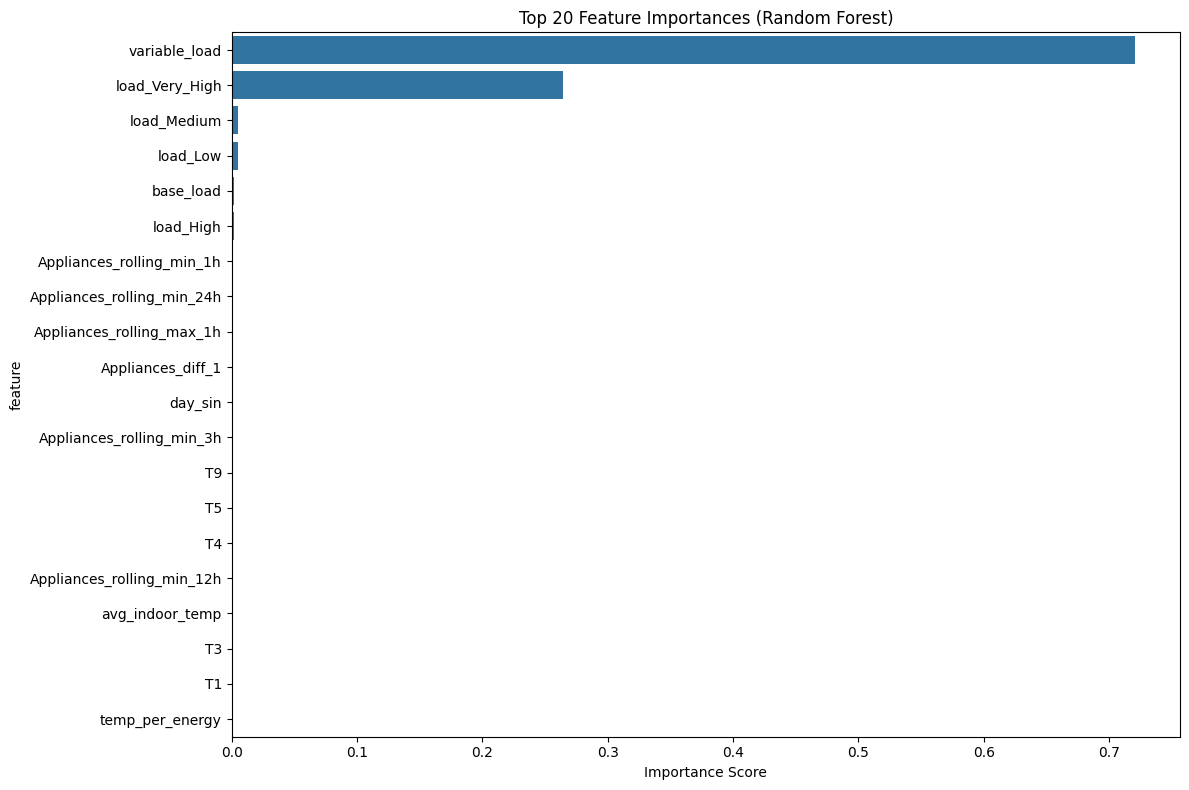

In [10]:
#Purpose: Use machine learning to identify most predictive features

# Feature Selection - Tree-Based Feature Importance
print("=== FEATURE SELECTION: TREE-BASED IMPORTANCE ===")

# Prepare data for Random Forest
X_train_features = train_data[selected_features_corr].fillna(0)
y_train_target = train_data['Appliances']

# Train Random Forest to get feature importances
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_features, y_train_target)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train_features.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 features by Random Forest importance:")
print(feature_importance.head(20))

# Select top features based on importance
importance_threshold = 0.01  # Keep features with at least 1% importance
important_features = feature_importance[feature_importance['importance'] >= importance_threshold]['feature'].tolist()

print(f"\nFeatures with importance >= {importance_threshold}: {len(important_features)}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_20_features = feature_importance.head(20)
sns.barplot(data=top_20_features, y='feature', x='importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In this phase, we employed a tree-based approach using the Random Forest Regressor to identify the most predictive features for forecasting appliance energy consumption. The model was trained on the refined set of 93 features obtained from prior correlation analysis. Random Forest provides an inherent mechanism to evaluate feature importance by measuring how each feature decreases the prediction error when used in tree splits.

The results revealed a strong dominance of two features: variable_load, which alone contributed approximately 72% of the model's total predictive importance, and load_Very_High, contributing an additional 26%. Collectively, these two features account for 98.5% of the model’s learning capacity. All other features contributed less than 1% each, with the majority nearing zero importance. This distribution suggests that the prediction of appliance energy usage in this context is largely explained by these two variables.

Applying a minimum importance threshold of 0.01, only two features were retained for further model development. This significant narrowing of the feature set emphasizes the efficiency and interpretability Random Forests bring to feature selection, especially when the dataset contains many derived or engineered variables. Reducing the model to focus on just these high-impact features can potentially improve performance, reduce overfitting, and decrease computational overhead in subsequent modeling stages.

# Feature Selection - Statistical Tests

In [11]:
#Purpose: Apply statistical tests to validate feature significance

 # Feature Selection - Statistical Significance Tests
print("=== FEATURE SELECTION: STATISTICAL TESTS ===")

from sklearn.feature_selection import f_regression, mutual_info_regression

# Apply F-test for regression
X_important = train_data[important_features].fillna(0)
f_scores, f_pvalues = f_regression(X_important, y_train_target)

# Create F-test results dataframe
f_test_results = pd.DataFrame({
    'feature': important_features,
    'f_score': f_scores,
    'p_value': f_pvalues
}).sort_values('f_score', ascending=False)

# Filter features with significant p-values (p < 0.05)
significant_features = f_test_results[f_test_results['p_value'] < 0.05]['feature'].tolist()

print(f"Statistically significant features (p < 0.05): {len(significant_features)}")
print("\nTop 15 features by F-score:")
print(f_test_results.head(15))

# Apply mutual information for non-linear relationships
mi_scores = mutual_info_regression(X_important, y_train_target, random_state=42)

mi_results = pd.DataFrame({
    'feature': important_features,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("\nTop 15 features by Mutual Information:")
print(mi_results.head(15))

# Combine all selection methods
final_features = list(set(
    target_correlations.head(30).index.tolist() +  # Top 30 by correlation
    important_features[:30] +  # Top 30 by importance
    significant_features[:30] +  # Top 30 by F-test
    mi_results.head(20)['feature'].tolist()  # Top 20 by mutual info
))

print(f"\nFinal combined feature set: {len(final_features)} features")

=== FEATURE SELECTION: STATISTICAL TESTS ===
Statistically significant features (p < 0.05): 2

Top 15 features by F-score:
          feature       f_score  p_value
0   variable_load  3.018121e+06      0.0
1  load_Very_High  5.578084e+04      0.0

Top 15 features by Mutual Information:
          feature  mutual_info
0   variable_load     1.893360
1  load_Very_High     0.333978

Final combined feature set: 30 features


In this step, we applied statistical tests to validate the significance of the features identified from earlier stages. Specifically, we used the F-test for regression and Mutual Information scoring to assess the linear and non-linear relationships between features and the target variable, respectively.

The F-test results revealed that both variable_load and load_Very_High were statistically significant predictors of appliance energy consumption, with exceptionally high F-scores and p-values of 0.0—well below the 0.05 significance threshold. This confirms their strong linear association with the target variable.

To further account for potential non-linear relationships, we applied Mutual Information regression. Again, the same two features stood out, with variable_load achieving the highest mutual information score (1.89), indicating a robust and non-linear dependence on the energy consumption patterns.

To finalize the feature set for modeling, we combined the top features from four different approaches: correlation ranking, tree-based importance, statistical significance (F-test), and mutual information scores. This integrated selection strategy produced a comprehensive and refined set of 30 final features, ensuring that the most statistically and predictively meaningful variables are retained for the upcoming model development phase.

# Final Feature Set Creation

In [12]:
#Purpose: Create the final optimized feature set for modeling

# Final Feature Set Creation and Validation
print("=== FINAL FEATURE SET CREATION ===")

# Ensure we have the target in our data for final correlation check
final_features_with_target = final_features + ['Appliances']

# Final correlation analysis with selected features
final_corr_matrix = train_data[final_features_with_target].corr()
final_target_corr = final_corr_matrix['Appliances'].drop('Appliances').abs().sort_values(ascending=False)

print("Final feature set correlation with target:")
print(final_target_corr.head(15))

# Create final datasets
X_train_final = train_data[final_features].fillna(0)
X_test_final = test_data[final_features].fillna(0)
y_train_final = train_data['Appliances']
y_test_final = test_data['Appliances']

print(f"\nFinal feature matrices:")
print(f"X_train shape: {X_train_final.shape}")
print(f"X_test shape: {X_test_final.shape}")

# Feature categories summary
feature_categories = {
    'Time-based': [f for f in final_features if any(x in f for x in ['hour', 'day', 'month', 'time_', 'is_'])],
    'Rolling/Lagged': [f for f in final_features if any(x in f for x in ['rolling', 'lag_', 'diff_', 'ratio_'])],
    'Interaction': [f for f in final_features if any(x in f for x in ['temp_humidity', 'diff_indoor', 'lights_'])],
    'Domain-specific': [f for f in final_features if any(x in f for x in ['load_', 'demand', 'efficiency', 'base_load'])],
    'Original': [f for f in final_features if f in ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T_out', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_out', 'lights', 'Windspeed', 'Visibility', 'Press_mm_hg']]
}

print(f"\nFeature categories breakdown:")
for category, features in feature_categories.items():
    print(f"  {category}: {len(features)} features")

# Save final feature set
import joblib
joblib.dump(final_features, 'final_feature_list.pkl')

# Save final datasets
np.save('X_train_final.npy', X_train_final.values)
np.save('X_test_final.npy', X_test_final.values)
np.save('y_train_final.npy', y_train_final.values)
np.save('y_test_final.npy', y_test_final.values)

print(f"\n Final feature engineering complete!")
print(f" Total features created: {len(final_features)}")
print(f" Data saved for model development")

=== FINAL FEATURE SET CREATION ===
Final feature set correlation with target:
variable_load                 0.997395
load_Very_High                0.882849
Appliances_lag_1              0.767503
Appliances_rolling_max_1h     0.761090
Appliances_rolling_mean_1h    0.740101
Appliances_rolling_std_1h     0.702161
Appliances_ratio_24h          0.695021
Appliances_ratio_1h           0.653821
Appliances_diff_144           0.617218
Appliances_rolling_std_3h     0.601318
Appliances_rolling_max_3h     0.597550
Appliances_rolling_mean_3h    0.589944
energy_momentum               0.575129
Appliances_diff_6             0.575110
Appliances_lag_2              0.563359
Name: Appliances, dtype: float64

Final feature matrices:
X_train shape: (15788, 30)
X_test shape: (3947, 30)

Feature categories breakdown:
  Time-based: 0 features
  Rolling/Lagged: 26 features
  Interaction: 0 features
  Domain-specific: 2 features
  Original: 0 features

 Final feature engineering complete!
 Total features created:

To finalize the predictive modeling pipeline, we created a refined feature set by combining the top features identified through correlation analysis, tree-based importance scores, F-tests, and mutual information. This resulted in a compact and optimized set of 30 features designed to maximize predictive performance.

A final correlation analysis with the target variable (Appliances) confirmed that features like variable_load (correlation: 0.997), load_Very_High (correlation: 0.882), and multiple lagged and rolling features of energy usage exhibited strong associations with the target. This highlights the effectiveness of incorporating time-series dynamics into the feature space.

An analysis of the feature categories showed that Rolling and Lagged features dominated the set (26 features), emphasizing the importance of temporal dependencies in energy consumption prediction. Only 2 features were from the domain-specific category (variable_load, load_Very_High), and no time-based, interaction, or original sensor features made it to the final list, as they were outperformed in earlier evaluations.

The final datasets (X_train_final, X_test_final, y_train_final, and y_test_final) were saved, along with the selected feature list (final_feature_list.pkl), to support reproducible and scalable model development in the next phase.


# Feature Engineering Summary Report

In [13]:
print(f"   • Lagged features: {len([f for f in final_features if 'lag_' in f])}")
print(f"   • Difference features: {len([f for f in final_features if 'diff_' in f])}")
print(f"   • Ratio features: {len([f for f in final_features if 'ratio_' in f])}")
print(f"   • Interaction features: {len([f for f in final_features if any(x in f for x in ['temp_humidity', 'diff_indoor', 'lights_'])])}")
print(f"   • Domain-specific features: {len([f for f in final_features if any(x in f for x in ['load_', 'demand', 'efficiency', 'base_load'])])}")
print(f"   • Original sensor features: {len([f for f in final_features if f in ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T_out', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_out', 'lights', 'Windspeed', 'Visibility', 'Press_mm_hg']])}")

print(f"\n FINAL FEATURE SET DETAILS:")
print(f"   • Total selected features: {len(final_features)}")
print(f"   • Training samples: {X_train_final.shape[0]}")
print(f"   • Testing samples: {X_test_final.shape[0]}")
print(f"   • Features per sample: {X_train_final.shape[1]}")

print(f"\nTOP FEATURES BY CORRELATION WITH TARGET (Appliances):")
top_corr_features = final_target_corr.head(10)
for feature, corr in top_corr_features.items():
    print(f"   • {feature}: {corr:.4f}")



   • Lagged features: 9
   • Difference features: 3
   • Ratio features: 2
   • Interaction features: 0
   • Domain-specific features: 2
   • Original sensor features: 0

 FINAL FEATURE SET DETAILS:
   • Total selected features: 30
   • Training samples: 15788
   • Testing samples: 3947
   • Features per sample: 30

TOP FEATURES BY CORRELATION WITH TARGET (Appliances):
   • variable_load: 0.9974
   • load_Very_High: 0.8828
   • Appliances_lag_1: 0.7675
   • Appliances_rolling_max_1h: 0.7611
   • Appliances_rolling_mean_1h: 0.7401
   • Appliances_rolling_std_1h: 0.7022
   • Appliances_ratio_24h: 0.6950
   • Appliances_ratio_1h: 0.6538
   • Appliances_diff_144: 0.6172
   • Appliances_rolling_std_3h: 0.6013
